# --

## Setup

* IMPORT

In [18]:
import keras
import numpy as np
from numpy import ma
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import  classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import random

* Set random state

In [ ]:
random_state = 42

* CHECK FOR GPU

In [19]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

* LOAD DATA

In [20]:
# Load all data and labels
ccFieldsAll = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/ccLastImageNoCloudIndex0_6234.npy", allow_pickle=True)
labels = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/reLabelsAll.npy", allow_pickle=True)

# Cloud probability band subset
cloud_probability = ccFieldsAll[:len(labels),:,:,7]

# Subset data to true labels
ccFieldsAll = ccFieldsAll[:len(labels),:,:,[2,1,0]]

## Normalize data to 0-255 range

In [21]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return (((band-band_min)/((band_max - band_min)))*255)

ccFieldsAll[:,:,:,0] = normalize(ccFieldsAll[:,:,:,0])
ccFieldsAll[:,:,:,1] = normalize(ccFieldsAll[:,:,:,1])
ccFieldsAll[:,:,:,2] = normalize(ccFieldsAll[:,:,:,2])

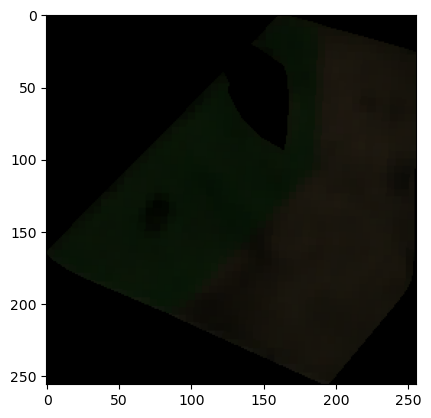

In [22]:
plt.imshow(ccFieldsAll[1])

Cloud masking

In [23]:
# We Set cloud tolerance, between 0-255
cloud_tolerance = 40
    
# We loop in the fields by the length of the dataset
for i in range(len(ccFieldsAll)):
    # we subset the image we are at in the loop
    image = ccFieldsAll[i,:,:,:]    
    # We create and apply a mask based on cloud probability over a certain value
    # We use np.logical because np.where did not work for me at the moment
    mask = np.logical_and(cloud_probability[i, :, :,] >= cloud_tolerance, cloud_probability[i, :, :] <= 256)
    # We set all masked pixels to zero, to black out cloud covered parts
    # I do not know why but it didn't work when i did not make a copy. It is just one of those times. 
    masked = image.copy()
    masked[mask] = 0
    # We are replacing the current image with the one with applied cloud mask, if no clouds then nothing is removed.
    ccFieldsAll[i] = masked

* DELETE EMPTY IMAGES, resize while were at it

In [24]:
# we want to delete the all black images, this is done by only appending images with visible RGB bands not all black.

# Initiate list for images that did not get blacked out as well as a list for labels
ccFieldsNoCloud = []
LabelsNoCloud = []

# as we are looping in the images we resize them at the same time
# so we set the size of the images
size = 128

# We loop in all the images
for i in range(len(ccFieldsAll)):
    # if the image is not all black
    if not np.all(ccFieldsAll[i] == 0):
        #we append the image and label
        ccFieldsNoCloud.append(tf.image.resize(ccFieldsAll[i], [size, size]))
        LabelsNoCloud.append(labels[i])

# We set the lists as arrays
ccFieldsNoCloud = np.array(ccFieldsNoCloud)
LabelsNoCloud   = np.array(LabelsNoCloud)

#And print the shapes to control the output and see how many fields are left. 
print(ccFieldsNoCloud.shape)
print(LabelsNoCloud.shape)

(6122, 128, 128, 3)
(6122,)


* NEW DISTRIBUTION OF LABELS

In [25]:
print(f'Number of observations : {len(LabelsNoCloud)}')

print(f'appearances of 0 in labels : {np.count_nonzero(LabelsNoCloud == 0)}({round(100*np.count_nonzero(LabelsNoCloud == 0)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(LabelsNoCloud == 1)}({round(100*np.count_nonzero(LabelsNoCloud == 1)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(LabelsNoCloud == 2)}({round(100*np.count_nonzero(LabelsNoCloud == 2)/len(LabelsNoCloud),2)}% of total)')

Number of observations : 6122
appearances of 0 in labels : 999(16.32% of total)
appearances of 1 in labels : 1325(21.64% of total)
appearances of 2 in labels : 3798(62.04% of total)


### CNN (RGB images)

In [26]:
# Data is split 80/20 for train and test
X_train, X_test, y_train, y_test = train_test_split(ccFieldsNoCloud, 
                                                    LabelsNoCloud, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

# Train data is split 75/25, which corresponds to 20% of original 
# data as validation and 60% of original data as train
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=random_state) # 0.25 x 0.8 = 0.2

# Print the dataset shapes to inspect sizes
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(3672, 128, 128, 3) (3672,)
(1225, 128, 128, 3) (1225,)
(1225, 128, 128, 3) (1225,)


# Data augmentation

In [27]:
#Defining augmentaation method 
 
datagen = ImageDataGenerator(
    # Rotation range is set to 360 to enable images to get any rotational angle
    rotation_range      = 360,        
    # Zoom range is a conservative 0.2 to not get too big parts of the image out of bounds
    zoom_range          = 0.2,           
    # Brightness range is random between specified values to enable brightness adjustment due to sun or shadow from clouds
    brightness_range    = (0.8,1.2),    
    # Horisontal flip is enabled. I do not know if it is going to make a difference, but it is not going to hurt. 
    horizontal_flip     = True)

In [28]:
# We initiate lists for data and labels used for augmentation
data_for_augmentation = []
labels_for_augmentation = []

# We Loop Loop data and append fields to each class for single class data augmentation 
for i in range(len(y_train)):
  if y_train[i] == 0:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])
  if y_train[i] == 1:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])

# save as numpy arrays
data_for_augmentation    = np.asarray(data_for_augmentation)
labels_for_augmentation    = np.asarray(labels_for_augmentation)

# Check  array shape
print(f'data for augmentation : {data_for_augmentation.shape} labels for augmentation : {labels_for_augmentation.shape}')

data for augmentation : (1412, 128, 128, 3) labels for augmentation : (1412,)


In [29]:
# We set a specified number of images for augmentation per image in the dataset
num_samples_per_image = 7
# num_samples_per_image = 9
# num_samples_per_image = 11

# We reshaping data, i am not sure why, but stack overflow helped me get here.
aug_dataset            = data_for_augmentation.reshape(data_for_augmentation.shape[0], 
                                                      data_for_augmentation.shape[1], 
                                                      data_for_augmentation.shape[2], 
                                                      3)

# We initiate a list of labels for augmented data
labels_aug = []
# We create an empty list for the augmented images
augmented_images = []

# We loop in the length of the dataset
for i in range(len(aug_dataset)):
    # We loop in the desired amount of images augmented for each image
    for j in range(num_samples_per_image):
        # we subset the image
        img = data_for_augmentation[i]
        # we expand dimensions as described on the tensorflow website 
        # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator 
        img = np.expand_dims(img, axis=0)
        # We use the datagen.flow to flow one image at the time into the augmenting imagedatagenerator
        # I am not entirely sure about the .next when using only one image but it works, in theory we do not need it but i do not want to remove something when it works. 
        augmented_img = datagen.flow(img, batch_size=1, shuffle=False).next()
        #as we have expanded the dimensiong we need to sqeeze it all back together for a functioning image again
        augmented_img = augmented_img.squeeze(axis=0)
        # We append the image and labels to our lists
        augmented_images.append(augmented_img)
        labels_aug.append(labels_for_augmentation[i])

#Turn it all into numpy arrays
labels_aug=np.asarray(labels_aug)
augmented_images=np.asarray(augmented_images)

In [30]:
# We concatenate the data to make sure the training dataset is now the original train data and the augmented data
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, labels_aug), axis=0)

In [ ]:
# We shuffle the data to ensure there is not only accepted fields in the start of the dataset
# we set a list of indexes that is randomly shuffled
idx = np.random.permutation(len(X_train))
# We use these indexes to set the images with corresponding labels
X_trainx,y_train = X_train[idx], y_train[idx]

In [31]:
print(f'Number of observations : {len(y_train)}')

print(f'appearances of 0 in labels : {np.count_nonzero(y_train == 0)}({round(100*np.count_nonzero(y_train == 0)/len(y_train),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(y_train == 1)}({round(100*np.count_nonzero(y_train == 1)/len(y_train),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(y_train == 2)}({round(100*np.count_nonzero(y_train == 2)/len(y_train),2)}% of total)')

Number of observations : 13556
appearances of 0 in labels : 4832(35.64% of total)
appearances of 1 in labels : 6464(47.68% of total)
appearances of 2 in labels : 2260(16.67% of total)


# Deep Learning Models

In [32]:
X_train = tf.keras.applications.vgg19.preprocess_input(X_train, data_format=None)
X_test = tf.keras.applications.vgg19.preprocess_input(X_test, data_format=None)
X_val = tf.keras.applications.vgg19.preprocess_input(X_val, data_format=None)

# VGG19 - Hyperparametersearch

In [ ]:
def His_metrics(history, cp_filepath):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(f'Training and Validation Loss {cp_filepath}')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(f'Training and Validation Loss {cp_filepath}')
    plt.xlabel('epoch')
    plt.show()

def Viz_metrics(X_test, y_test, model, cp_filepath):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(classification_report(y_test, y_pred_classes))
    cm = confusion_matrix(y_test, y_pred_classes)
    class_names = ['Failed (0)', 'Partially (1)', 'Accepted (2)']
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap=plt.cm.OrRd)
    plt.title(f'Confusion Matrix \n {cp_filepath}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    for k in range(len(class_names)):
        for h in range(len(class_names)):
            plt.text(h, k, cm[k, h], ha='center', va='center', color='black')

    plt.show()        


In [33]:
histories = []
name = []

ft_histories = []
ft_name = []

### lr=0.0001 bs=64 - done

Running learning rate:[0.0001] and batch size: [64] for epochs: 100
Running: 
 learning rate:0.0001, batch size: 64 for epochs: 100
Epoch 1/100
212/212 [==============================] - 30s 101ms/step - loss: 1.3611 - accuracy: 0.5360 - val_loss: 0.9823 - val_accuracy: 0.6057
Epoch 2/100
212/212 [==============================] - 17s 79ms/step - loss: 0.7090 - accuracy: 0.6662 - val_loss: 1.2031 - val_accuracy: 0.5086
Epoch 3/100
212/212 [==============================] - 17s 80ms/step - loss: 0.5519 - accuracy: 0.7498 - val_loss: 1.0835 - val_accuracy: 0.5690
Epoch 4/100
212/212 [==============================] - 17s 80ms/step - loss: 0.4172 - accuracy: 0.8232 - val_loss: 1.1230 - val_accuracy: 0.5829
Epoch 5/100
212/212 [==============================] - 17s 80ms/step - loss: 0.2840 - accuracy: 0.8950 - val_loss: 1.2398 - val_accuracy: 0.5698
Epoch 6/100
212/212 [==============================] - 17s 79ms/step - loss: 0.2067 - accuracy: 0.9292 - val_loss: 1.3730 - val_accuracy: 0.55

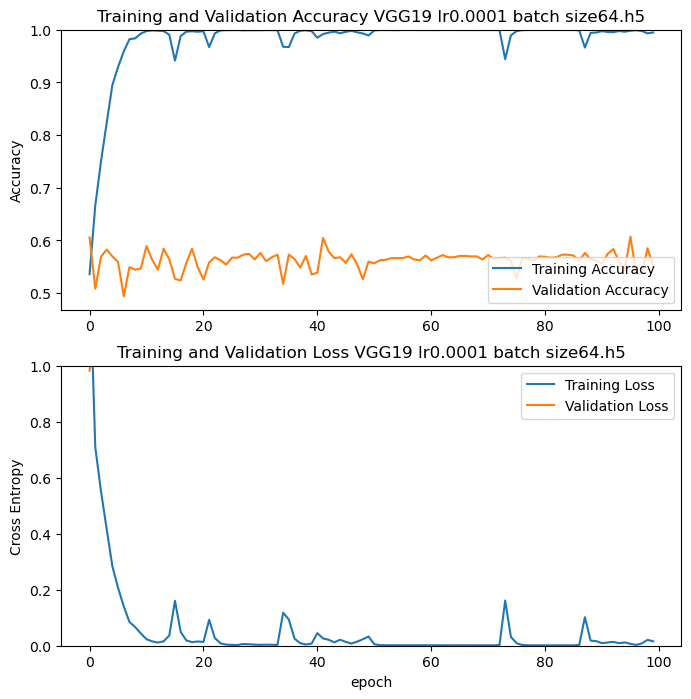

39/39 [==============================] - 2s 36ms/step
              precision    recall  f1-score   support

           0       0.35      0.35      0.35       208
           1       0.31      0.32      0.32       250
           2       0.76      0.74      0.75       767

    accuracy                           0.59      1225
   macro avg       0.47      0.47      0.47      1225
weighted avg       0.59      0.59      0.59      1225



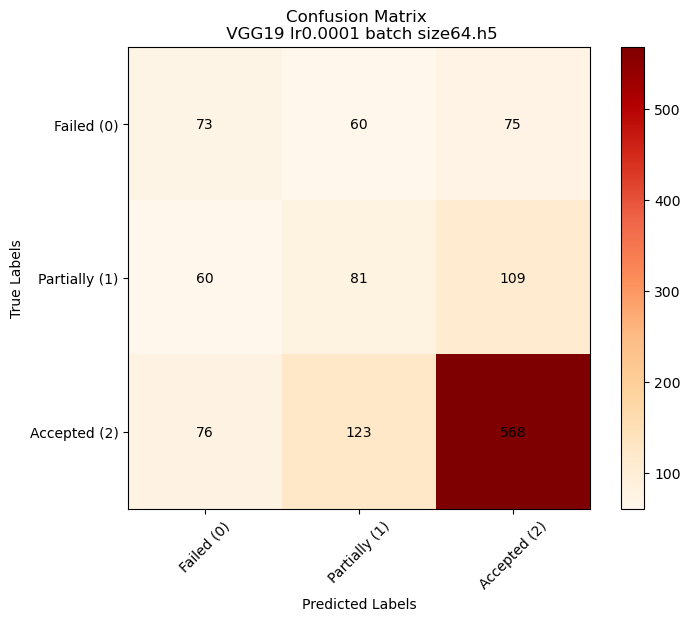

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
____________________________________________

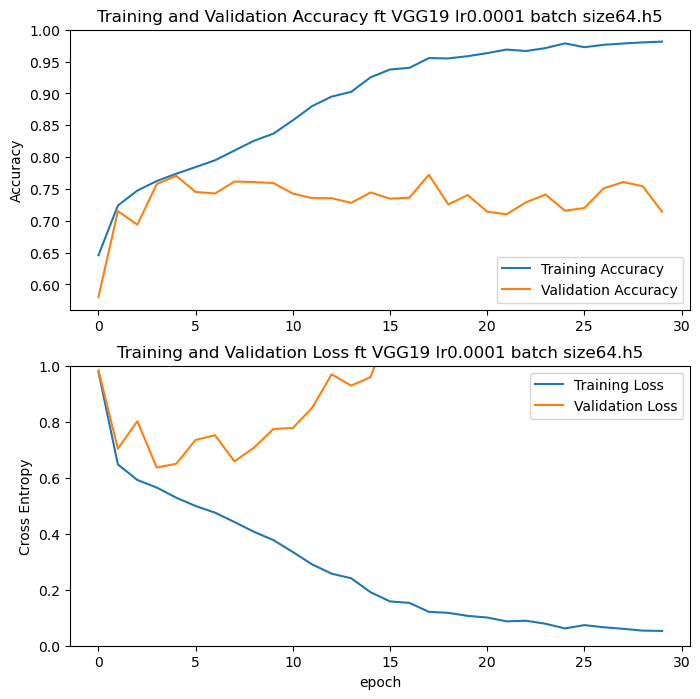

39/39 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       208
           1       0.53      0.39      0.45       250
           2       0.83      0.90      0.86       767

    accuracy                           0.76      1225
   macro avg       0.68      0.65      0.66      1225
weighted avg       0.74      0.76      0.74      1225



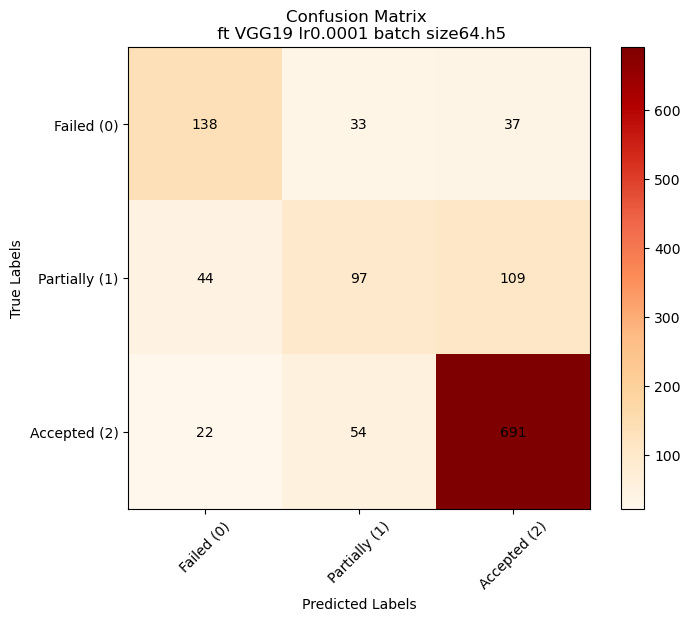

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.0001]
batch_size = [64]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

### lr=0,0001 bs=32 - done

Running learning rate:[0.0001] and batch size: [32] for epochs: 100
Running: 
 learning rate:0.0001, batch size: 32 for epochs: 100
Epoch 1/100
424/424 [==============================] - 29s 50ms/step - loss: 1.1859 - accuracy: 0.5390 - val_loss: 1.6160 - val_accuracy: 0.3559
Epoch 2/100
424/424 [==============================] - 19s 44ms/step - loss: 0.7147 - accuracy: 0.6613 - val_loss: 1.1275 - val_accuracy: 0.5445
Epoch 3/100
424/424 [==============================] - 19s 44ms/step - loss: 0.5419 - accuracy: 0.7540 - val_loss: 1.1276 - val_accuracy: 0.5518
Epoch 4/100
424/424 [==============================] - 18s 43ms/step - loss: 0.3881 - accuracy: 0.8378 - val_loss: 1.3049 - val_accuracy: 0.5396
Epoch 5/100
424/424 [==============================] - 18s 43ms/step - loss: 0.2551 - accuracy: 0.9036 - val_loss: 1.4764 - val_accuracy: 0.5200
Epoch 6/100
424/424 [==============================] - 19s 44ms/step - loss: 0.1550 - accuracy: 0.9490 - val_loss: 1.4509 - val_accuracy: 0.594

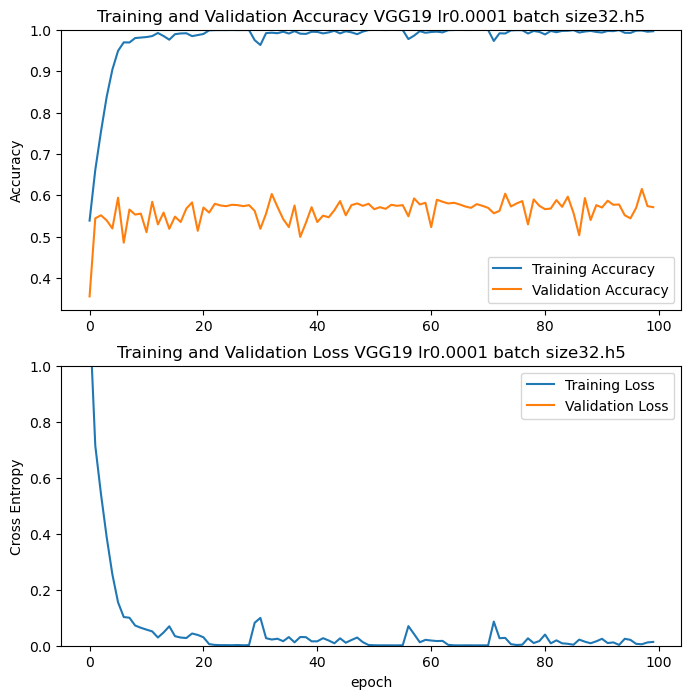

39/39 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.38      0.41      0.39       208
           1       0.30      0.26      0.28       250
           2       0.75      0.76      0.76       767

    accuracy                           0.60      1225
   macro avg       0.47      0.48      0.47      1225
weighted avg       0.59      0.60      0.60      1225



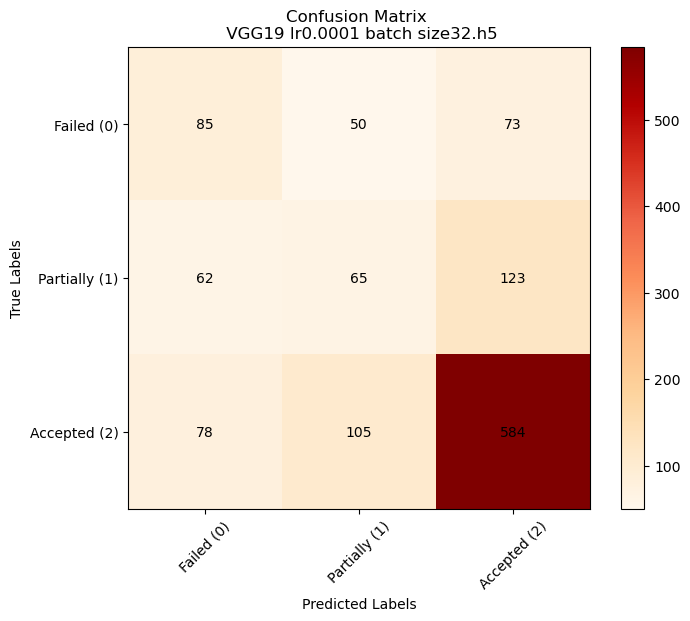

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
____________________________________________

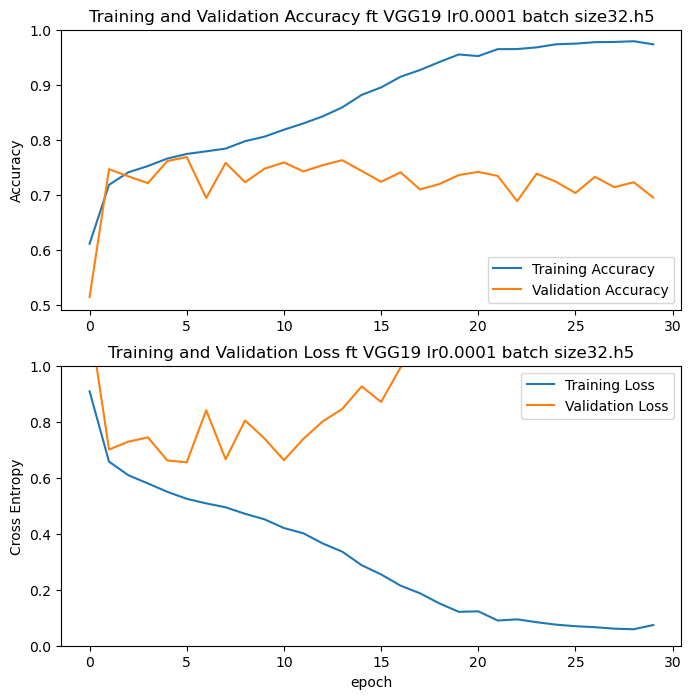

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       208
           1       0.54      0.30      0.39       250
           2       0.81      0.92      0.86       767

    accuracy                           0.76      1225
   macro avg       0.69      0.65      0.66      1225
weighted avg       0.74      0.76      0.74      1225



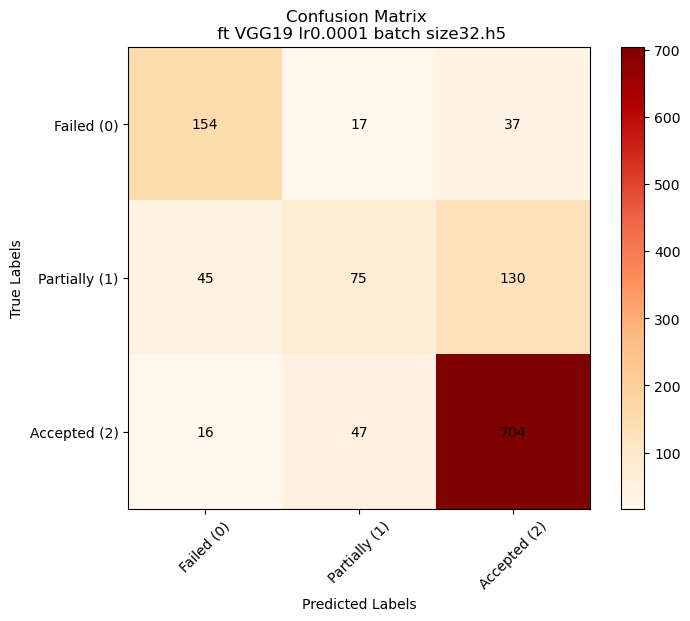

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.0001]
batch_size = [32]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

### lr=0.0001 bs=16 - done

Running learning rate:[0.0001] and batch size: [16] for epochs: 100
Running: 
 learning rate:0.0001, batch size: 16 for epochs: 100
Epoch 1/100
848/848 [==============================] - 32s 29ms/step - loss: 1.1440 - accuracy: 0.5427 - val_loss: 1.0774 - val_accuracy: 0.5233
Epoch 2/100
848/848 [==============================] - 23s 27ms/step - loss: 0.7108 - accuracy: 0.6575 - val_loss: 1.0878 - val_accuracy: 0.5486
Epoch 3/100
848/848 [==============================] - 22s 26ms/step - loss: 0.5458 - accuracy: 0.7534 - val_loss: 1.1899 - val_accuracy: 0.5012
Epoch 4/100
848/848 [==============================] - 23s 27ms/step - loss: 0.3823 - accuracy: 0.8426 - val_loss: 1.3376 - val_accuracy: 0.5951
Epoch 5/100
848/848 [==============================] - 22s 26ms/step - loss: 0.2483 - accuracy: 0.9023 - val_loss: 1.5435 - val_accuracy: 0.5657
Epoch 6/100
848/848 [==============================] - 22s 26ms/step - loss: 0.1719 - accuracy: 0.9394 - val_loss: 1.7671 - val_accuracy: 0.557

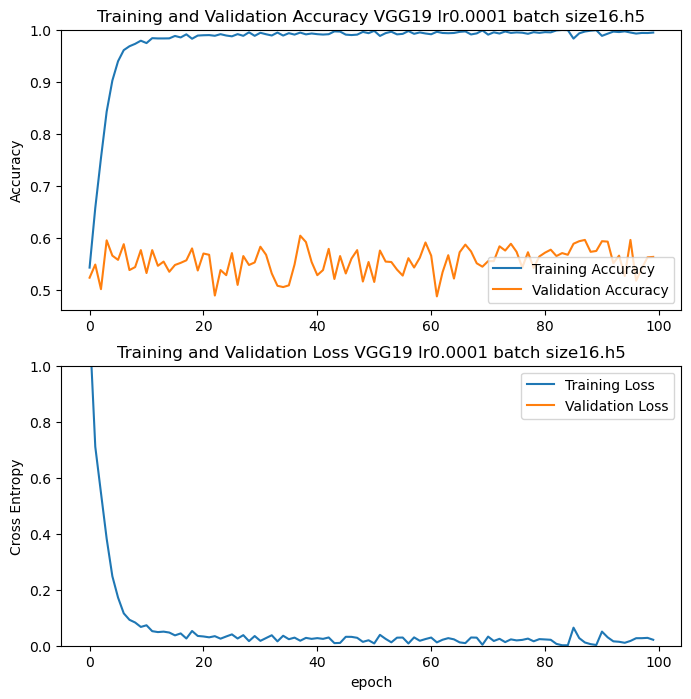

39/39 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.40      0.34      0.37       208
           1       0.26      0.26      0.26       250
           2       0.73      0.75      0.74       767

    accuracy                           0.58      1225
   macro avg       0.46      0.45      0.46      1225
weighted avg       0.58      0.58      0.58      1225



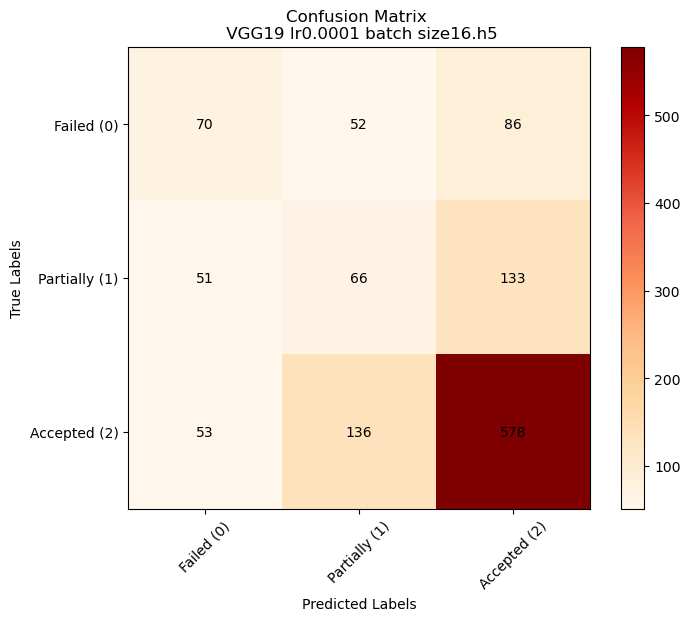

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
____________________________________________

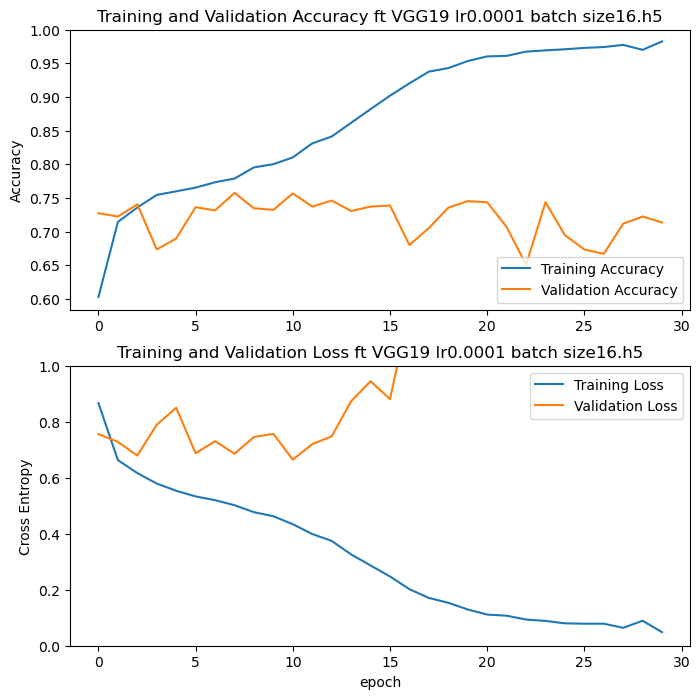

39/39 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       208
           1       0.52      0.50      0.51       250
           2       0.84      0.87      0.86       767

    accuracy                           0.76      1225
   macro avg       0.70      0.68      0.69      1225
weighted avg       0.76      0.76      0.76      1225



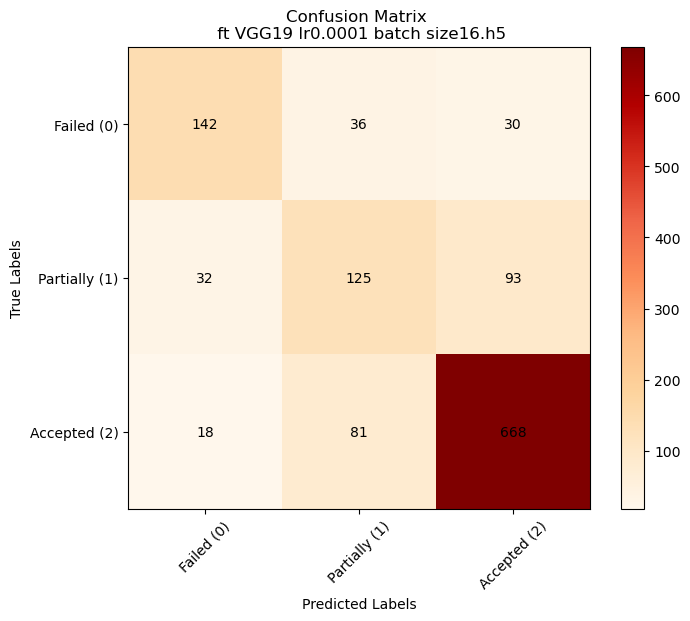

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.0001]
batch_size = [16]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

### lr=0,001 bs=64 - done

Running learning rate:[0.001] and batch size: [64] for epochs: 100
Running: 
 learning rate:0.001, batch size: 64 for epochs: 100
Epoch 1/100
212/212 [==============================] - 30s 99ms/step - loss: 1.9942 - accuracy: 0.5491 - val_loss: 0.8946 - val_accuracy: 0.6220
Epoch 2/100
212/212 [==============================] - 17s 78ms/step - loss: 0.7276 - accuracy: 0.6414 - val_loss: 0.9719 - val_accuracy: 0.6131
Epoch 3/100
212/212 [==============================] - 17s 78ms/step - loss: 0.6574 - accuracy: 0.6844 - val_loss: 1.0185 - val_accuracy: 0.6016
Epoch 4/100
212/212 [==============================] - 17s 78ms/step - loss: 0.5865 - accuracy: 0.7211 - val_loss: 1.1704 - val_accuracy: 0.5624
Epoch 5/100
212/212 [==============================] - 17s 78ms/step - loss: 0.5085 - accuracy: 0.7676 - val_loss: 1.3078 - val_accuracy: 0.5943
Epoch 6/100
212/212 [==============================] - 17s 78ms/step - loss: 0.4458 - accuracy: 0.7970 - val_loss: 1.3866 - val_accuracy: 0.6155


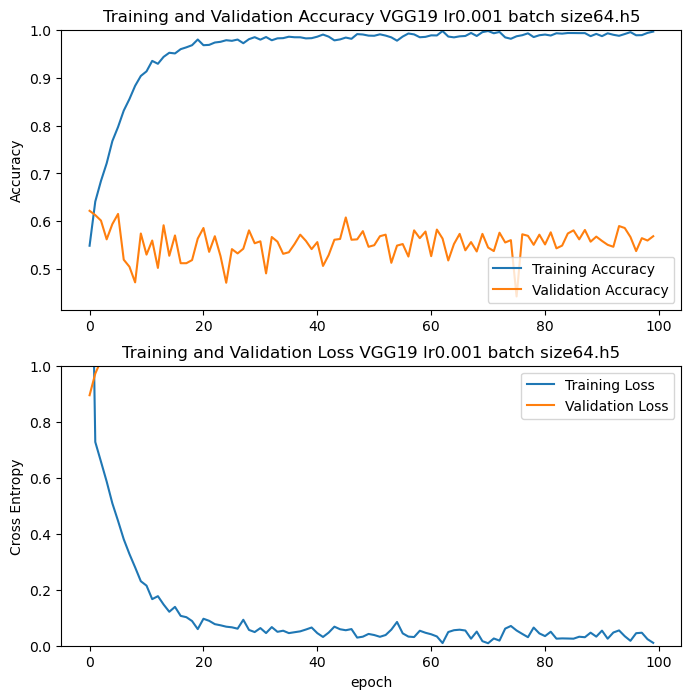

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.38      0.40      0.39       208
           1       0.25      0.12      0.16       250
           2       0.72      0.83      0.77       767

    accuracy                           0.61      1225
   macro avg       0.45      0.45      0.44      1225
weighted avg       0.57      0.61      0.58      1225



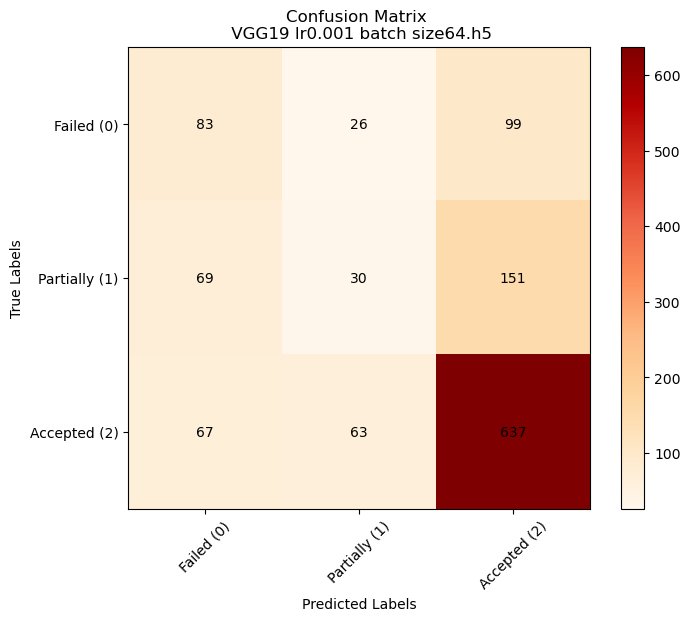

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
____________________________________________

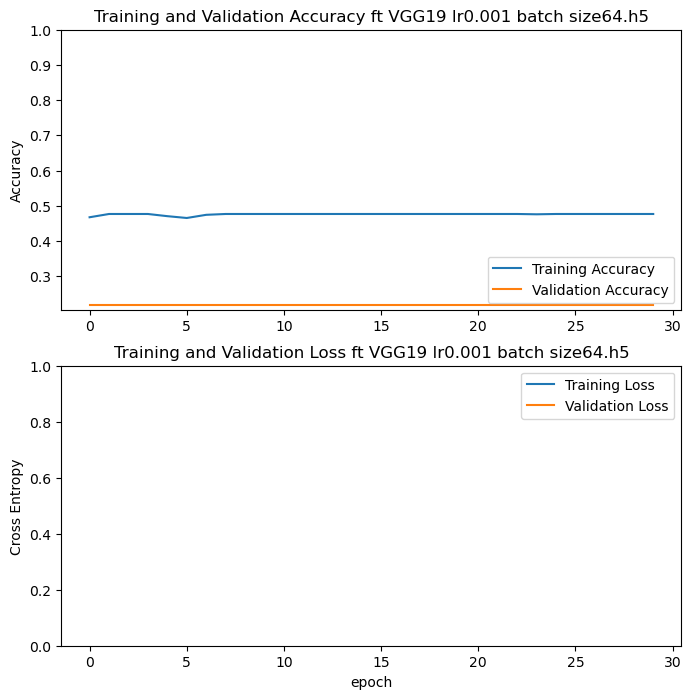

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


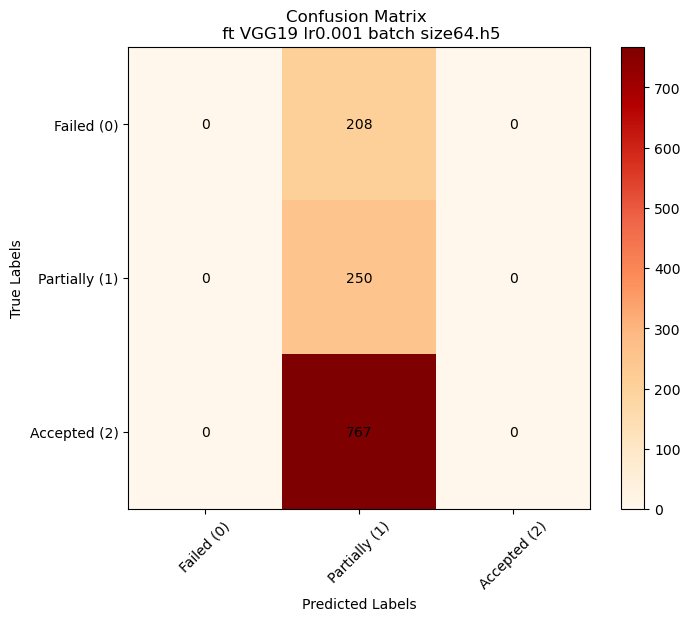

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.001]
batch_size = [64]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

### lr 0,001 bs=32 - done

Running learning rate:[0.001] and batch size: [32] for epochs: 100
Running: 
 learning rate:0.001, batch size: 32 for epochs: 100
Epoch 1/100
424/424 [==============================] - 29s 50ms/step - loss: 1.6414 - accuracy: 0.5506 - val_loss: 0.9380 - val_accuracy: 0.5771
Epoch 2/100
424/424 [==============================] - 18s 43ms/step - loss: 0.7625 - accuracy: 0.6205 - val_loss: 1.0108 - val_accuracy: 0.5592
Epoch 3/100
424/424 [==============================] - 19s 44ms/step - loss: 0.7147 - accuracy: 0.6429 - val_loss: 0.9371 - val_accuracy: 0.6294
Epoch 4/100
424/424 [==============================] - 18s 43ms/step - loss: 0.6637 - accuracy: 0.6680 - val_loss: 1.2423 - val_accuracy: 0.5045
Epoch 5/100
424/424 [==============================] - 18s 43ms/step - loss: 0.6170 - accuracy: 0.7006 - val_loss: 1.1623 - val_accuracy: 0.5812
Epoch 6/100
424/424 [==============================] - 18s 43ms/step - loss: 0.5582 - accuracy: 0.7312 - val_loss: 1.1050 - val_accuracy: 0.6220


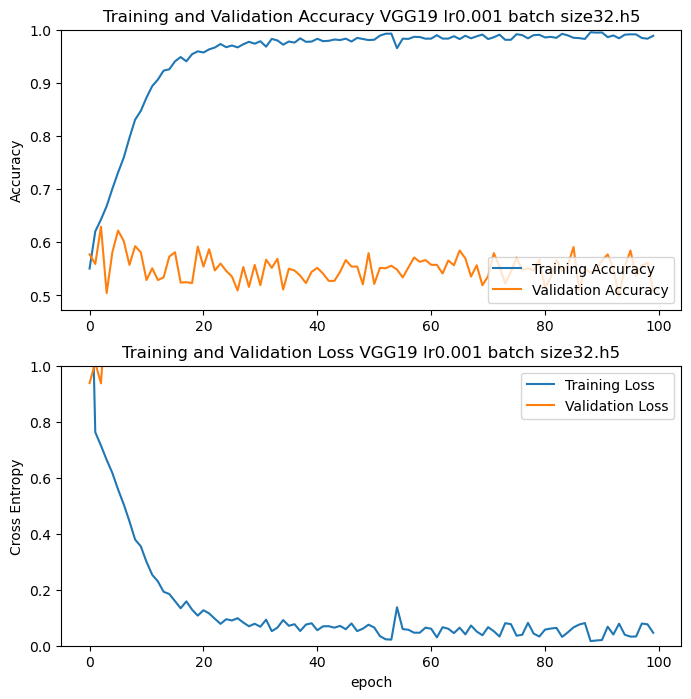

39/39 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.44      0.40      0.42       208
           1       0.30      0.22      0.26       250
           2       0.73      0.81      0.77       767

    accuracy                           0.62      1225
   macro avg       0.49      0.48      0.48      1225
weighted avg       0.59      0.62      0.61      1225



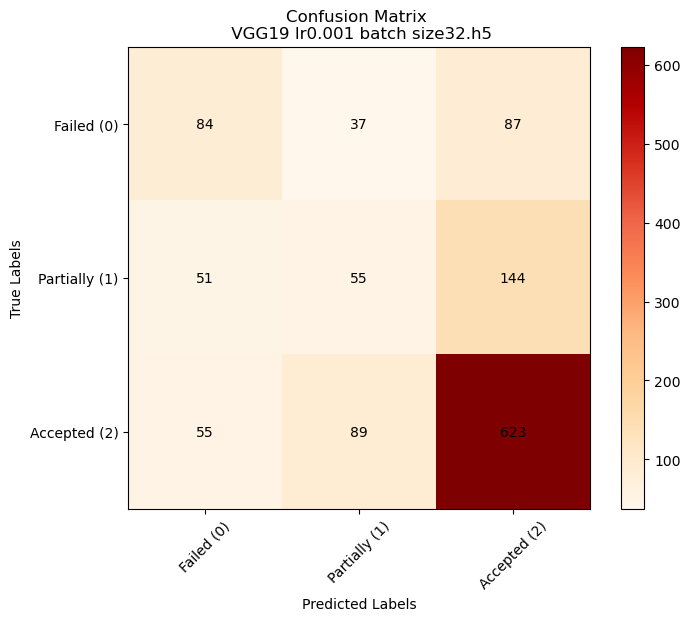

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
____________________________________________

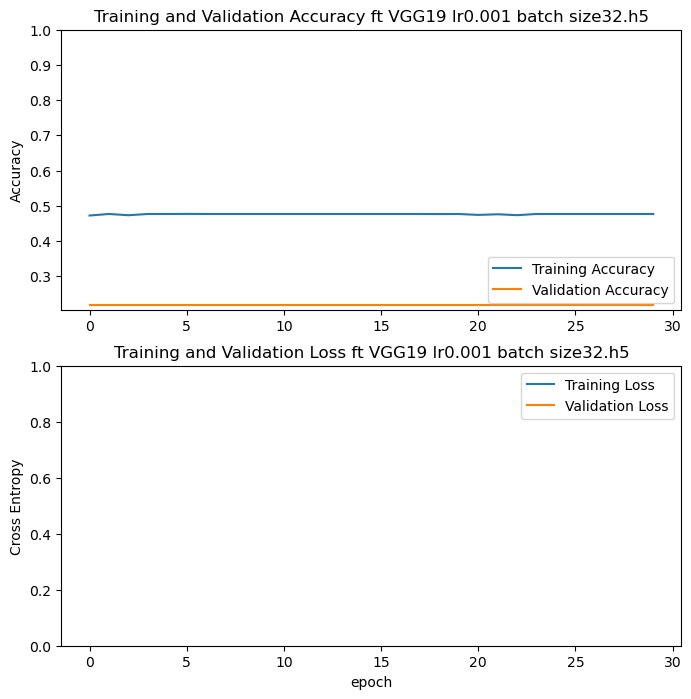

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


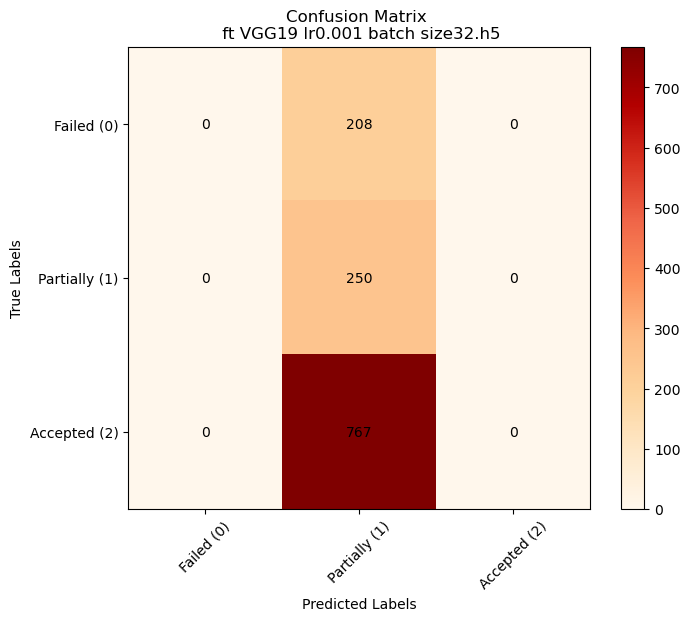

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.001]
batch_size = [32]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

### lr=0,001 bs=16 - done

Running 1 possible models with learning rates:[0.001] and batch sizes: [16] with dropouts: [0.5] for epochs: 100
Running: 
 learning rate:0.001, batch size: 16 with dropout: 0.5 for epochs: 100
Epoch 1/100
848/848 [==============================] - 29s 26ms/step - loss: 1.3736 - accuracy: 0.5084 - val_loss: 1.1145 - val_accuracy: 0.5086
Epoch 2/100
848/848 [==============================] - 20s 24ms/step - loss: 0.8326 - accuracy: 0.5690 - val_loss: 0.9796 - val_accuracy: 0.5567
Epoch 3/100
848/848 [==============================] - 20s 24ms/step - loss: 0.8065 - accuracy: 0.5826 - val_loss: 1.0594 - val_accuracy: 0.5241
Epoch 4/100
848/848 [==============================] - 20s 24ms/step - loss: 0.7947 - accuracy: 0.5904 - val_loss: 1.1750 - val_accuracy: 0.4816
Epoch 5/100
848/848 [==============================] - 20s 24ms/step - loss: 0.7764 - accuracy: 0.6126 - val_loss: 1.0360 - val_accuracy: 0.5731
Epoch 6/100
848/848 [==============================] - 20s 24ms/step - loss: 0.75

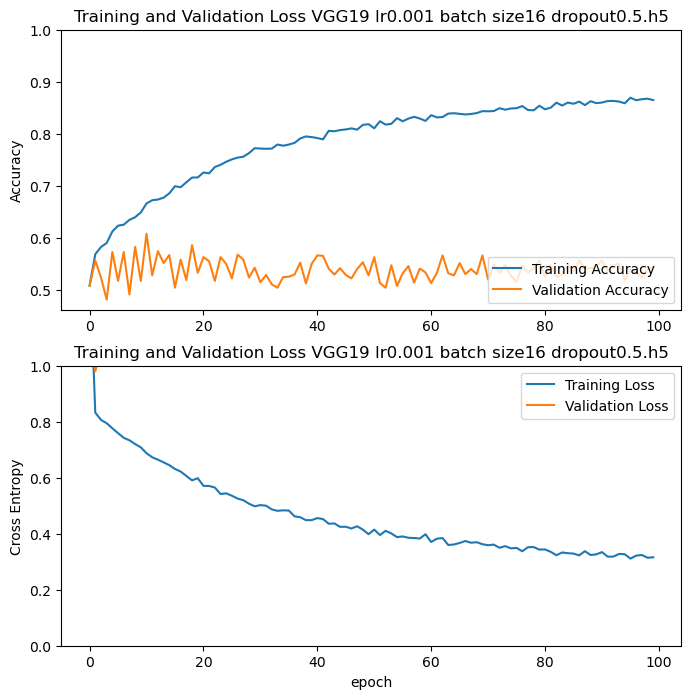

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.45      0.36      0.40       208
           1       0.31      0.38      0.34       250
           2       0.77      0.75      0.76       767

    accuracy                           0.61      1225
   macro avg       0.51      0.50      0.50      1225
weighted avg       0.62      0.61      0.61      1225



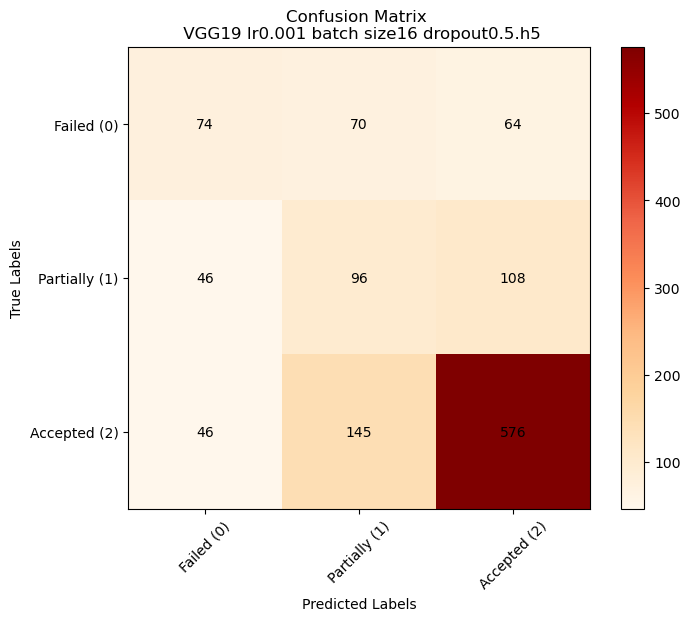

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 20,288,579
Trainable params: 20,288,579
Non-trainable params: 0
____________________________________________

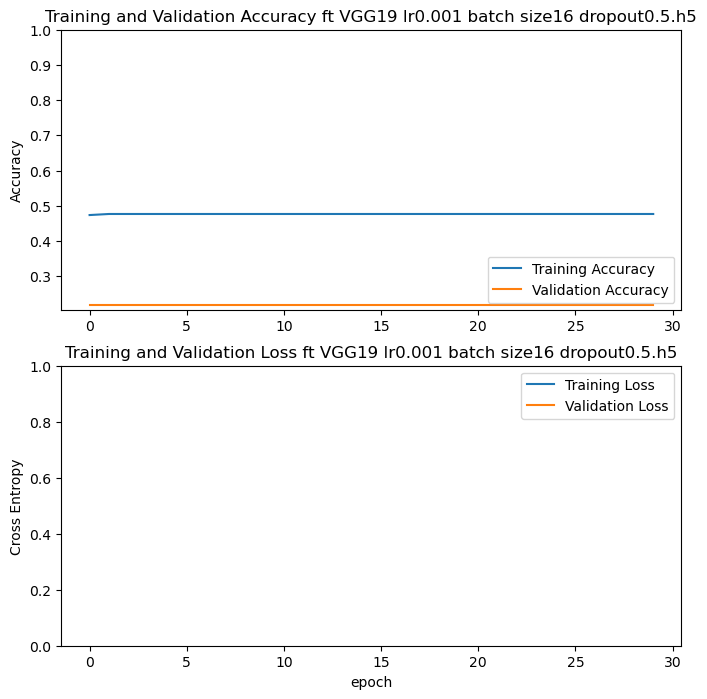

39/39 [==============================] - 1s 34ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


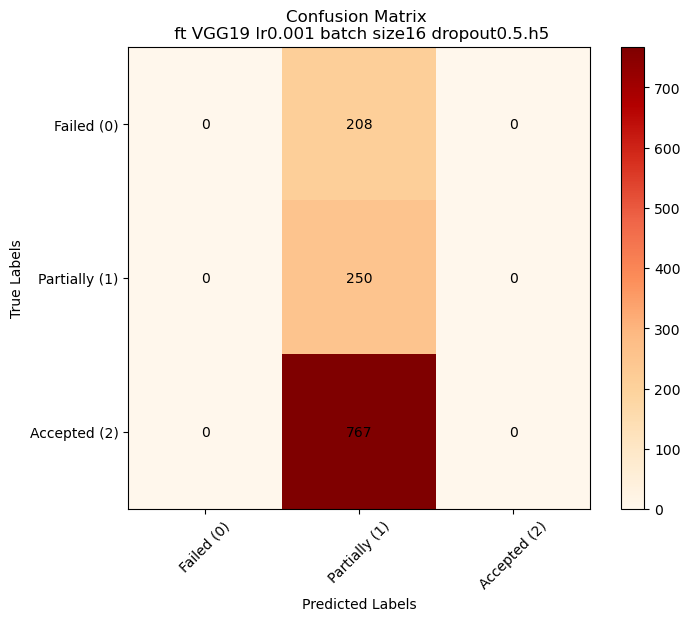

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.001]
batch_size = [16]
dropouts = [0.5]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running {len(learning_rate)*len(batch_size)*len(dropouts)} possible models with learning rates:{learning_rate} and batch sizes: {batch_size} with dropouts: {dropouts} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(512, activation='relu'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

### lr 0.01 bs 64 - done

Running learning rate:[0.01] and batch size: [64] for epochs: 100
Running: 
 learning rate:0.01, batch size: 64 for epochs: 100
Epoch 1/100
212/212 [==============================] - 31s 100ms/step - loss: 30.2305 - accuracy: 0.5095 - val_loss: 0.9677 - val_accuracy: 0.5747
Epoch 2/100
212/212 [==============================] - 17s 81ms/step - loss: 0.8280 - accuracy: 0.5704 - val_loss: 0.8839 - val_accuracy: 0.6163
Epoch 3/100
212/212 [==============================] - 17s 79ms/step - loss: 0.7854 - accuracy: 0.5955 - val_loss: 0.9063 - val_accuracy: 0.6082
Epoch 4/100
212/212 [==============================] - 17s 79ms/step - loss: 0.7654 - accuracy: 0.6108 - val_loss: 1.1229 - val_accuracy: 0.5649
Epoch 5/100
212/212 [==============================] - 17s 79ms/step - loss: 0.7533 - accuracy: 0.6166 - val_loss: 0.9802 - val_accuracy: 0.5812
Epoch 6/100
212/212 [==============================] - 17s 79ms/step - loss: 0.7473 - accuracy: 0.6258 - val_loss: 0.9493 - val_accuracy: 0.5910


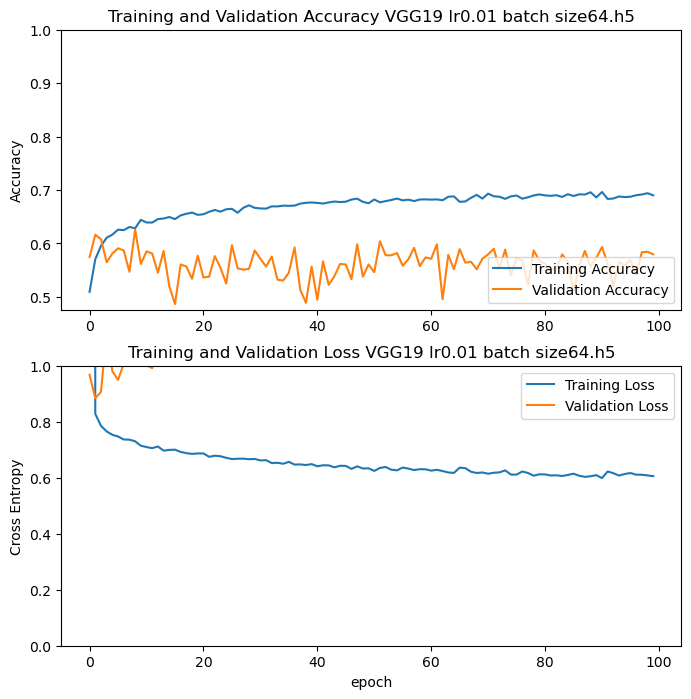

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.45      0.29      0.35       208
           1       0.31      0.33      0.32       250
           2       0.74      0.79      0.76       767

    accuracy                           0.61      1225
   macro avg       0.50      0.47      0.48      1225
weighted avg       0.60      0.61      0.60      1225



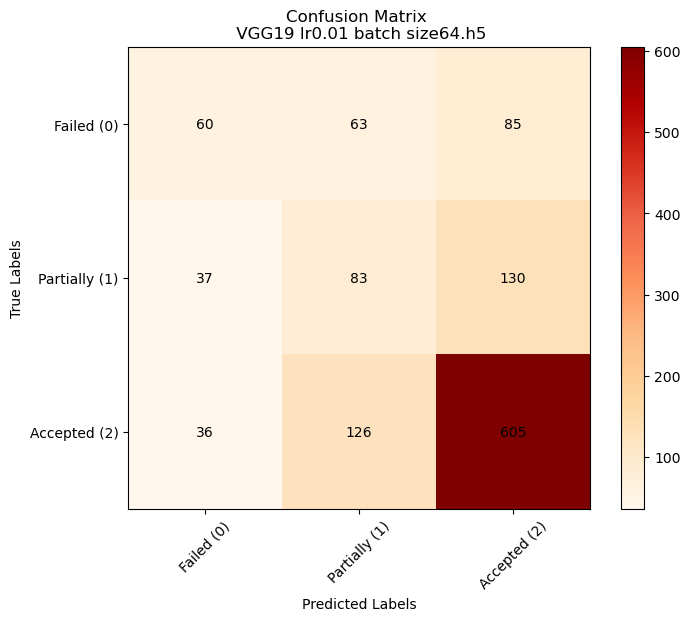

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
____________________________________________

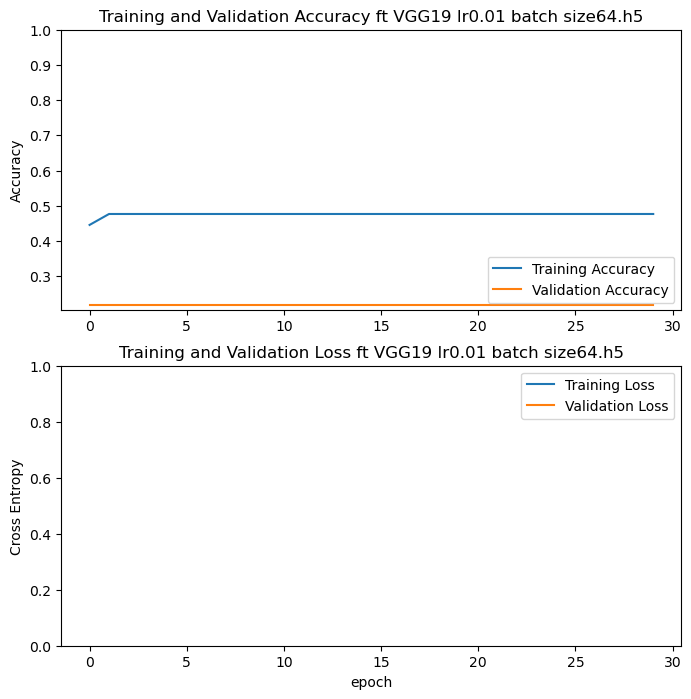

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


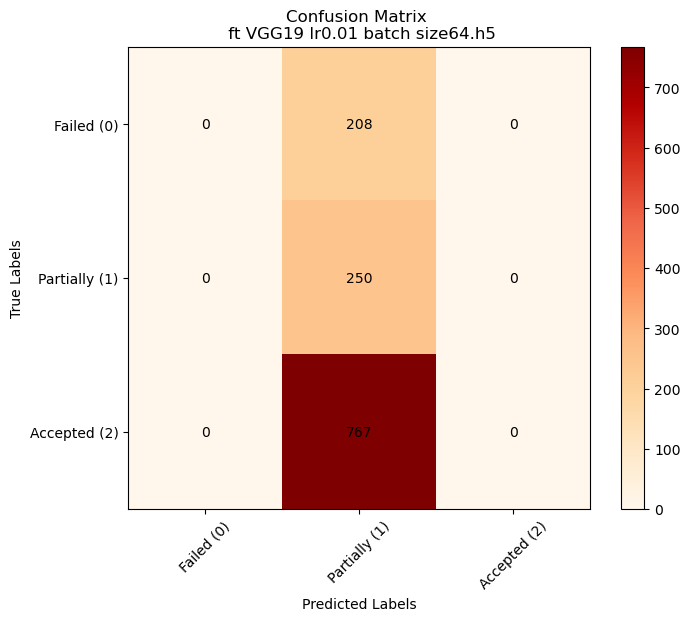

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.01]
batch_size = [64]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

### lr 0.01 bs32 - done

Running learning rate:[0.01] and batch size: [32] for epochs: 100
Running: 
 learning rate:0.01, batch size: 32 for epochs: 100
Epoch 1/100
424/424 [==============================] - 29s 50ms/step - loss: 12.4127 - accuracy: 0.4931 - val_loss: 1.1985 - val_accuracy: 0.5347
Epoch 2/100
424/424 [==============================] - 18s 43ms/step - loss: 0.8394 - accuracy: 0.5651 - val_loss: 1.1598 - val_accuracy: 0.4955
Epoch 3/100
424/424 [==============================] - 18s 43ms/step - loss: 0.7936 - accuracy: 0.5965 - val_loss: 1.0294 - val_accuracy: 0.5094
Epoch 4/100
424/424 [==============================] - 19s 44ms/step - loss: 0.7741 - accuracy: 0.6113 - val_loss: 1.0501 - val_accuracy: 0.5576
Epoch 5/100
424/424 [==============================] - 19s 44ms/step - loss: 0.7886 - accuracy: 0.6034 - val_loss: 0.9727 - val_accuracy: 0.6057
Epoch 6/100
424/424 [==============================] - 18s 43ms/step - loss: 0.8825 - accuracy: 0.5748 - val_loss: 1.5884 - val_accuracy: 0.2180
E

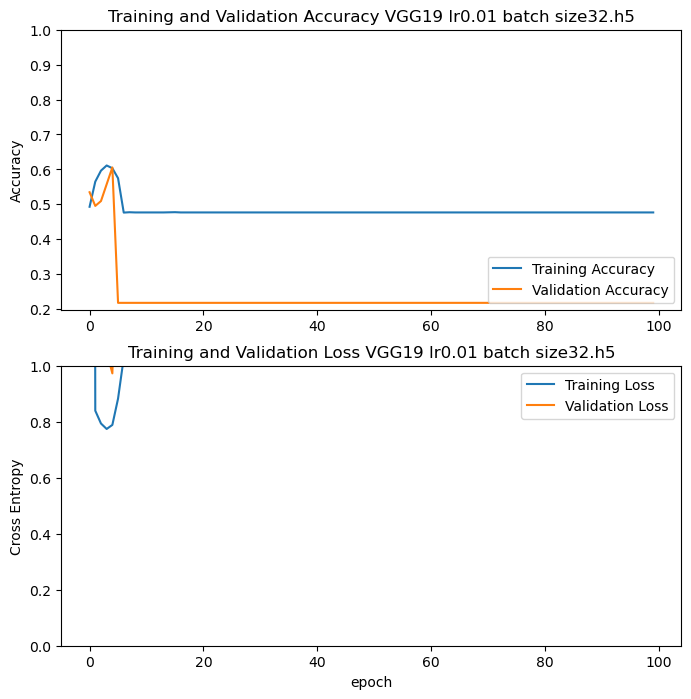

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.48      0.23      0.31       208
           1       0.29      0.44      0.35       250
           2       0.76      0.73      0.75       767

    accuracy                           0.59      1225
   macro avg       0.51      0.47      0.47      1225
weighted avg       0.62      0.59      0.59      1225



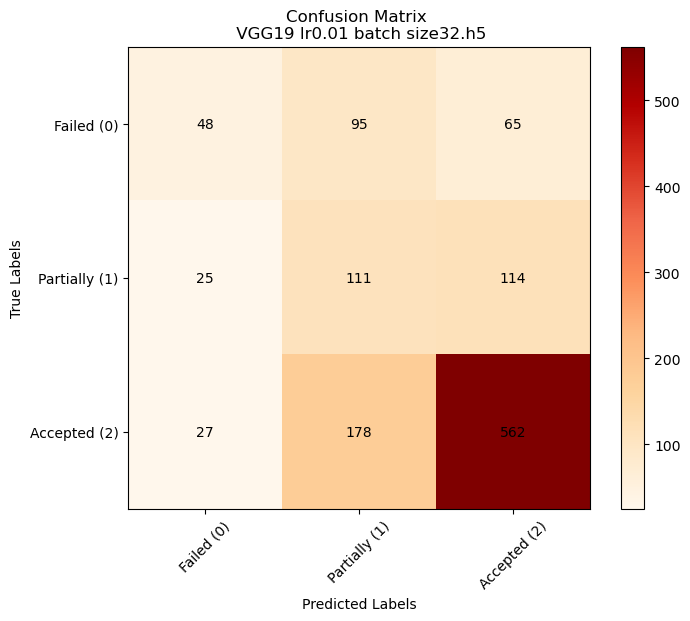

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
____________________________________________

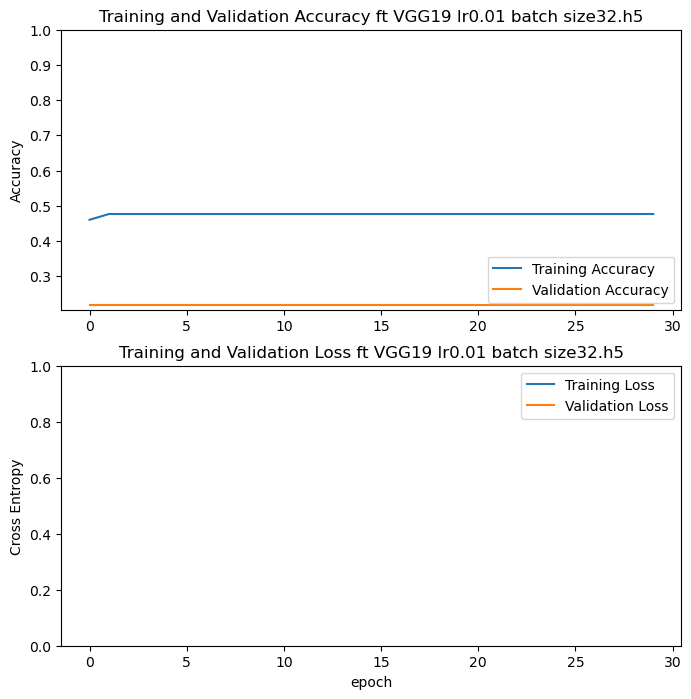

39/39 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


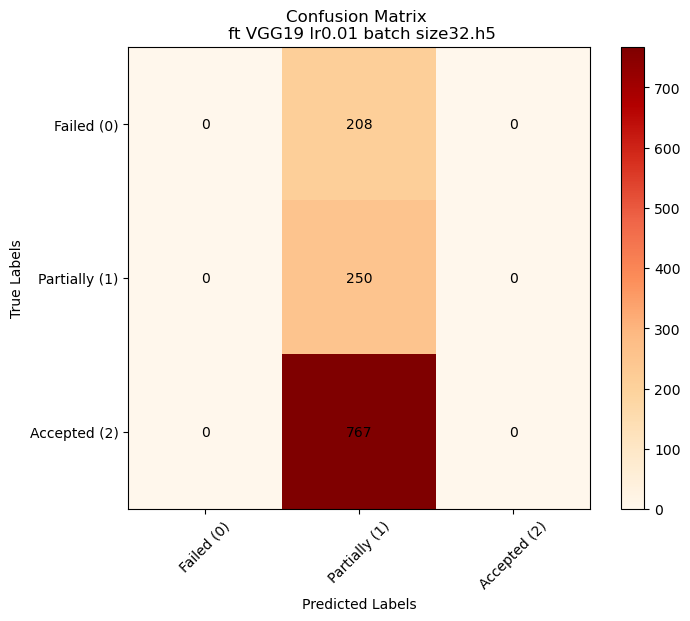

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.01]
batch_size = [32]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            acc = history.history['accuracy']
            val_acc = history.history['val_accuracy']

            loss = history.history['loss']
            val_loss = history.history['val_loss']

            plt.figure(figsize=(8, 8))
            plt.subplot(2, 1, 1)
            plt.plot(acc, label='Training Accuracy')
            plt.plot(val_acc, label='Validation Accuracy')
            plt.legend(loc='lower right')
            plt.ylabel('Accuracy')
            plt.ylim([min(plt.ylim()),1])
            plt.title(f'Training and Validation Accuracy {cp_filepath}')

            plt.subplot(2, 1, 2)
            plt.plot(loss, label='Training Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.legend(loc='upper right')
            plt.ylabel('Cross Entropy')
            plt.ylim([0,1.0])
            plt.title(f'Training and Validation Loss {cp_filepath}')
            plt.xlabel('epoch')
            plt.show()

            #################################################################################################################### 
            #       Generate predictions on the test set

            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)

            print(classification_report(y_test, y_pred_classes))

            ####################################################################################################################
            #       We Generate a confusion matrix
            cm = confusion_matrix(y_test, y_pred_classes)

            ####################################################################################################################
            #       Define the class labels
            class_names = ['Failed (0)', 'Partially (1)', 'Accepted (2)']

            ####################################################################################################################
            #       Plot the confusion matrix
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, cmap=plt.cm.OrRd)
            plt.title(f'Confusion Matrix \n {cp_filepath}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
            plt.yticks(np.arange(len(class_names)), class_names)
            plt.colorbar()

            ####################################################################################################################
            #       Add labels to the plot

            for k in range(len(class_names)):
                for h in range(len(class_names)):
                    plt.text(h, k, cm[k, h], ha='center', va='center', color='black')

            plt.show()

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            acc = history.history['accuracy']
            val_acc = history.history['val_accuracy']

            loss = history.history['loss']
            val_loss = history.history['val_loss']

            plt.figure(figsize=(8, 8))
            plt.subplot(2, 1, 1)
            plt.plot(acc, label='Training Accuracy')
            plt.plot(val_acc, label='Validation Accuracy')
            plt.legend(loc='lower right')
            plt.ylabel('Accuracy')
            plt.ylim([min(plt.ylim()),1])
            plt.title(f'Training and Validation Accuracy {cp_filepath}')

            plt.subplot(2, 1, 2)
            plt.plot(loss, label='Training Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.legend(loc='upper right')
            plt.ylabel('Cross Entropy')
            plt.ylim([0,1.0])
            plt.title(f'Training and Validation Loss {cp_filepath}')
            plt.xlabel('epoch')
            plt.show()

            # Generate predictions on the test set
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)

            print(classification_report(y_test, y_pred_classes))

            # Compute the confusion matrix
            cm = confusion_matrix(y_test, y_pred_classes)

            # Define the class labels
            class_names = ['Failed (0)', 'Partially (1)', 'Accepted (2)']

            # Plot the confusion matrix
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, cmap=plt.cm.OrRd)
            plt.title(f'Confusion Matrix \n {cp_filepath}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
            plt.yticks(np.arange(len(class_names)), class_names)
            plt.colorbar()

            # Add labels to the plot
            for k in range(len(class_names)):
                for h in range(len(class_names)):
                    plt.text(h, k, cm[k, h], ha='center', va='center', color='black')

            plt.show()

### lr0.01 bs16 - Done

Running learning rate:[0.01] and batch size: [16] for epochs: 100
Running: 
 learning rate:0.01, batch size: 16 for epochs: 100
Epoch 1/100
848/848 [==============================] - 25s 27ms/step - loss: 10.5885 - accuracy: 0.5159 - val_loss: 1.0397 - val_accuracy: 0.6204
Epoch 2/100
848/848 [==============================] - 22s 26ms/step - loss: 0.8967 - accuracy: 0.5374 - val_loss: 1.0357 - val_accuracy: 0.4890
Epoch 3/100
848/848 [==============================] - 22s 26ms/step - loss: 0.8637 - accuracy: 0.5385 - val_loss: 1.0719 - val_accuracy: 0.4563
Epoch 4/100
848/848 [==============================] - 22s 26ms/step - loss: 0.8357 - accuracy: 0.5612 - val_loss: 1.1553 - val_accuracy: 0.5257
Epoch 5/100
848/848 [==============================] - 22s 26ms/step - loss: 0.8258 - accuracy: 0.5715 - val_loss: 1.0148 - val_accuracy: 0.5690
Epoch 6/100
848/848 [==============================] - 22s 26ms/step - loss: 0.8151 - accuracy: 0.5726 - val_loss: 0.9267 - val_accuracy: 0.5608
E

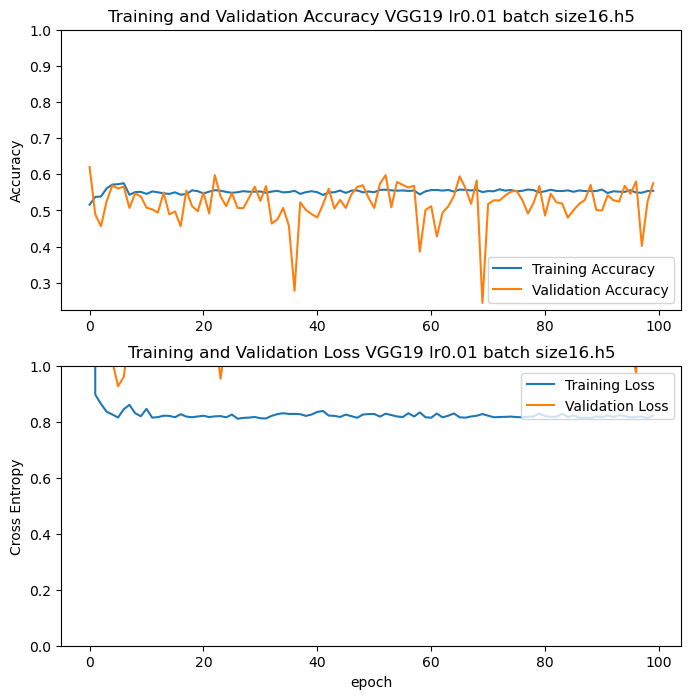

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.32      0.48      0.38       250
           2       0.74      0.82      0.78       767

    accuracy                           0.61      1225
   macro avg       0.35      0.43      0.39      1225
weighted avg       0.53      0.61      0.56      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


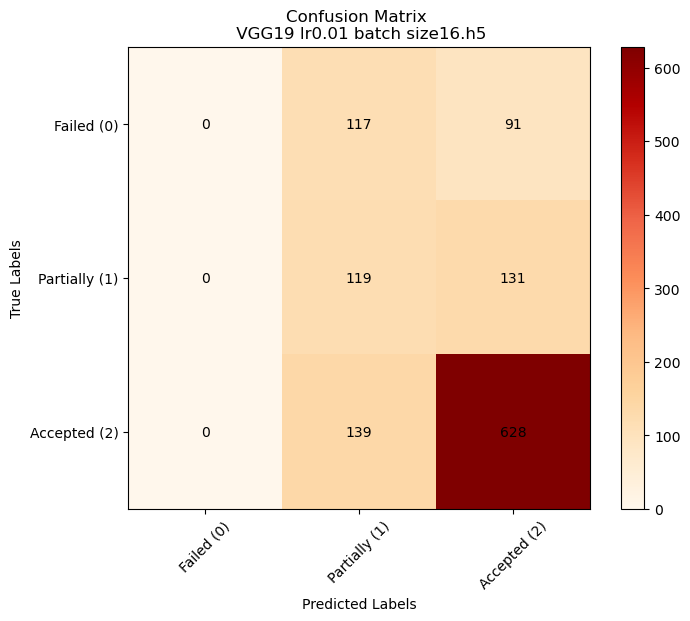

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             (None, 4096)              2101248   
                                                                 
 dense_4 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_5 (Dense)             (None, 3)                 12291     
                                                                 
Total params: 38,919,235
Trainable params: 38,919,235
Non-trainable params: 0
__________________________________________

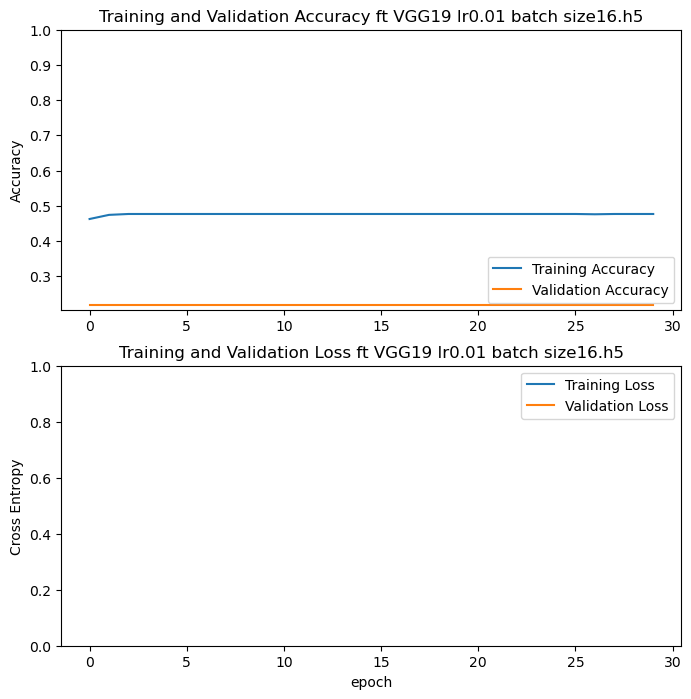

39/39 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


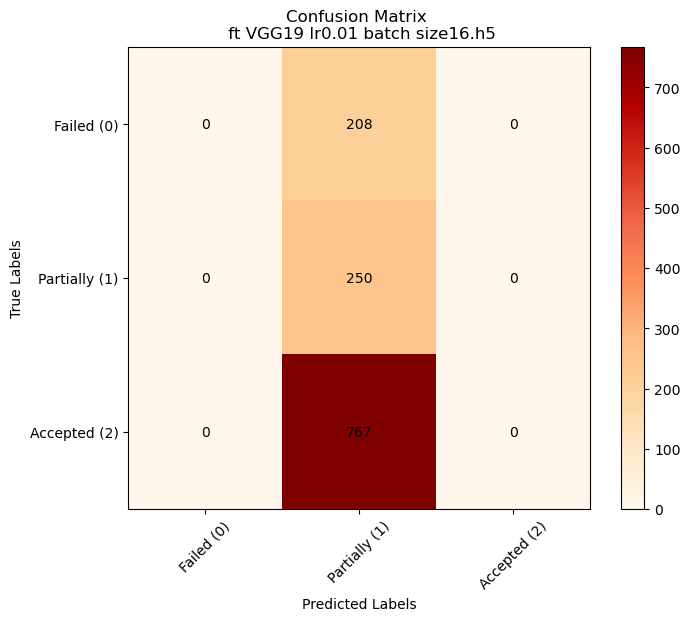

In [34]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.01]
batch_size = [16]

####################################################################################################################
#           We define our model specific parameters

model_name = "VGG19" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running learning rate:{learning_rate} and batch size: {batch_size} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dense(4096, activation='relu'),   
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{}.h5'.format(model_name,score[1], i,j,))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{}.h5'.format(model_name, i,j,)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{}.h5'.format(model_name,score[1], i,j,))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)         